In [3]:
import random
import torch
import numpy as np

import gym
from gym.wrappers import Monitor
import json
import sys
import glob
import io
import base64
import os
import matplotlib.pyplot as plt
%matplotlib inline
import hiplot as hip
import plotly.express as px
import cv2
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from tqdm.notebook import tqdm

from rich.jupyter import print
from torch import nn
from collections import deque 
device = torch.device("cuda") if (torch.cuda.is_available()) else torch.device("cpu")
print(device)

cpu

In [4]:
display = Display(visible=0, size=(1024, 768))
display.start()

In [5]:
class ReplayMemory(object):

    def __init__(self, capacity):
        # Define a queue with maxlen "capacity"
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward):
        # Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append( (state, action, next_state, reward) )

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples 
        # if the requested batch_size is higher than the number of sample currently in the memory
        # Randomly select "batch_size" samples and return the selection
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [6]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
    mp4list = glob.glob('video/*.mp4')
    mp4list.sort()
    for mp4 in mp4list:
        print(f"\nSHOWING VIDEO {mp4}")
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
    env = Monitor(env, './video', force=True, video_callable=video_callable)
    return env


def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()



def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()



### Define exploration profile
def expl_profile_softmax(num_iterations, initial_value):
    # We compute the exponential decay in such a way the shape of the 
    # exploration profile does not depend on the number of iterations
    if initial_value == 1:
        exploration_profile = np.array([np.exp(-i / num_iterations * 6 ) for i in range(num_iterations)])
    else:    
        exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) 
        exploration_profile = np.array([initial_value * (exp_decay ** i) for i in range(num_iterations)])

    return exploration_profile



def initialize(params, replay_memory_capacity=10000, state_space_dim=4, action_space_dim=2):
    ### Initialize the replay memory
    replay_mem = ReplayMemory(replay_memory_capacity)    

    ### Initialize the policy network
    policy_net = DQN(state_space_dim, action_space_dim)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQN(state_space_dim, action_space_dim)
    # Copy the weights of the policy network to the target network
    target_net.load_state_dict(policy_net.state_dict()) 
    
    ### Initialize the optimizer
    # The optimizer will update ONLY the parameters of the policy network
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=params['learning_rate']) 
    
    ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
    
    return replay_mem, policy_net, target_net, optimizer, loss_fn


def update_step(policy_net, target_net, replay_mem, optimizer, loss_fn, params):
    
    gamma = params['gamma']
    batch_size = params['batch_size']
    
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states  = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states 
    # (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) 
    # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    # Set the required tensor shape
    expected_state_action_values = expected_state_action_values.unsqueeze(1) 

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()
    
    
    
def train_loop(policy_net, target_net, replay_mem, exploration_profile, params):
    '''
    Function that defines the main training process
    '''

    # Initialize the Gym environment
    env = gym.make('CartPole-v1') 
    env.seed(0) # Set a random seed for the environment (reproducible results)
    
    # initialise output list containing all the scores
    scores = []

    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the pole falls off
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # IMPLEMENT FURTHER PENALTY HERE
            off_cen_penalty = 1.
            reward = reward - off_cen_penalty * np.abs(state[0])

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward += params['bad_state_penalty']
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > params['min_samples_for_training']: 
                # Enable the training only if there are enough samples in the replay memory
                # otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, optimizer, loss_fn, params)

            # Visually render the environment 
            # comment to speed up the training
            # env.render()

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % params['target_net_update_steps'] == 0:
            # Copy the weights of the policy network to the target network  
            target_net.load_state_dict(policy_net.state_dict()) 
        
        # Save score
        scores.append(score)
    
    env.close()
    
    return policy_net, scores
    
    

    
def random_params(params):
    selected_params = {}
    for i in params.keys():
        selected_params[i] = np.random.choice( params[i] )
    return selected_params

### Define exploration profile
def expl_profile_softmax(num_iterations, initial_value):
    # We compute the exponential decay in such a way the shape of the 
    # exploration profile does not depend on the number of iterations
    if initial_value == 1:
        exploration_profile = np.array([np.exp(-i / num_iterations * 6 ) for i in range(num_iterations)])
    else:    
        exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) 
        exploration_profile = np.array([initial_value * (exp_decay ** i) for i in range(num_iterations)])

    return exploration_profile




def train_loop_car(policy_net, target_net, replay_mem, exploration_profile, params):

    # Initialize the Gym environment
    env = gym.make('MountainCar-v0') # Initialize the Gym environment
    env.seed(0) # Set a random seed for the environment (reproducible results)
    
    # initialise output list containing all the scores and the car positions
    max_positions = []
    scores = []

    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score
        #score as the number of steps it takes to reach the goal, so the fewer, the better
        score = 0
        done = False
        max_position = state[0]

        # Go on until the ending conditions are met 
        # (position 0.5 is reached or episode lasts more than 200)
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)
            
      
            # moving left and pushing right = a reward
            if next_state[0] - state[0] > 0 and action == 2: reward += 1
             # moving right and pushing left = a reward   
            if next_state[0] - state[0] < 0 and action == 0: reward += 1  
            # set reward to +1 (and not 0 if the car wins the game )    
            if next_state[0] >=0.5 : reward += 1 
                
        
            score += reward

            # Tracking maximum reached distance
            if next_state[0] > max_position:
                max_position = next_state[0]
                
            # Apply penalty for bad state
            if done:
                reward += params['bad_state_penalty']
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > params['min_samples_for_training']: 
                # Enable the training only if there are enough samples in the replay memory
                # otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, optimizer, loss_fn, params)

            # Visually render the environment 
            # comment to speed up the training
            env.render()

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % params['target_net_update_steps'] == 0:
            # Copy the weights of the policy network to the target network  
            target_net.load_state_dict(policy_net.state_dict()) 

        # Print the final score
        print(f"EPISODE: {episode_num + 1} - Max Position: {max_position} - Score: {score} - Temperature: {tau}") # Print the final score
        # Save score
        max_positions.append(max_position)
        scores.append(score)
    
    env.close()
    
    return policy_net, max_positions, scores
    






In [7]:
# Define the replay memory
replay_mem = ReplayMemory(capacity=3)

# Push some samples
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(1,1,1,1)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(2,2,2,2)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(3,3,3,3)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(4,4,4,4)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(5,5,5,5)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")

# Check the content of the memory
print('\nCONTENT OF THE MEMORY')
print(replay_mem.memory)

# Random sample
print('\nRANDOM SAMPLING')
for i in range(5):
  print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

CURRENT MEMORY SIZE: 0

CURRENT MEMORY SIZE: 1

CURRENT MEMORY SIZE: 2

CURRENT MEMORY SIZE: 3

CURRENT MEMORY SIZE: 3

CURRENT MEMORY SIZE: 3

CONTENT OF THE MEMORY

deque([(3, 3, 3, 3), (4, 4, 4, 4), (5, 5, 5, 5)])

RANDOM SAMPLING

[(3, 3, 3, 3), (5, 5, 5, 5)]

[(5, 5, 5, 5), (4, 4, 4, 4)]

[(3, 3, 3, 3), (4, 4, 4, 4)]

[(5, 5, 5, 5), (4, 4, 4, 4)]

[(3, 3, 3, 3), (5, 5, 5, 5)]

In [8]:
# Define an example network
net = DQN(state_space_dim=4, action_space_dim=2)
print(net)

DQN(
  (linear): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [9]:
# Test if it works as expected
state = (0, 0, 0, 0)
epsilon = 0.6
chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1

Q-VALUES: [ 0.01883163 -0.06845678]

In [10]:
state = (0, 0, 0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1

Q-VALUES: [ 0.01883163 -0.06845678]

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

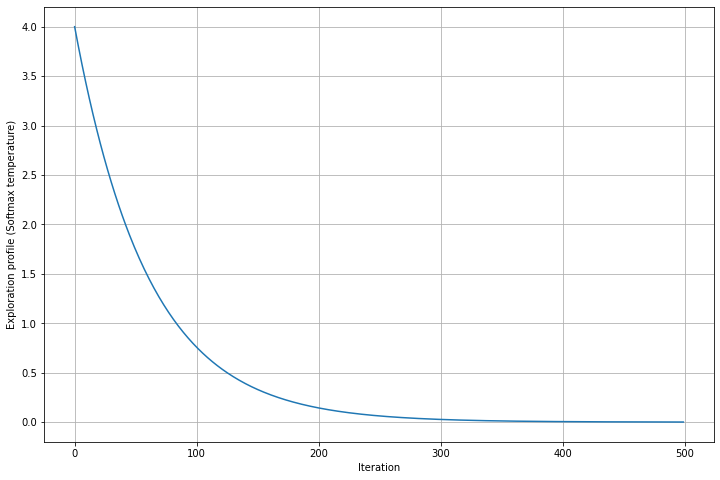

In [11]:
initial_value = 4
num_iterations = 500

exploration_profile = expl_profile_softmax(num_iterations,initial_value)

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [12]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 12:15:08,850] Making new env: CartPole-v1
/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


STATE SPACE SIZE: 4

ACTION SPACE SIZE: 2

ACTION SPACE SIZE: 2

In [13]:
### PARAMETERS

hyperparams = {'gamma': np.linspace(0.9, 0.99, 10),        # gamma parameter for the long term reward
               'replay_memory_capacity': [10000],          # Replay memory capacity
               'learning_rate': np.logspace(-3, -1, 10),   # Optimizer learning rate
               'target_net_update_steps': [5, 10, 15, 20], # Number of episodes to wait before updating the target network
               'batch_size': [ 64, 128,256,512],           # Number of samples to take from the replay memory for each update
               'bad_state_penalty': [0],                   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
               'min_samples_for_training': [1000]          # Minimum samples in the replay memory to enable the training
              }


In [14]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()


INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 12:15:12,579] Making new env: CartPole-v1
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2022-08-30 12:15:12,588] Clearing 2 monitor files from previous run (because force=True was provided)
INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.0.2370.video000000.mp4
[2022-08-30 12:15:12,596] Starting new video recorder writing to /content/video/openaigym.video.0.2370.video000000.mp4


EPISODE 1 - FINAL SCORE: 35.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.0.2370.video000001.mp4
[2022-08-30 12:15:13,954] Starting new video recorder writing to /content/video/openaigym.video.0.2370.video000001.mp4


EPISODE 2 - FINAL SCORE: 22.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.0.2370.video000002.mp4
[2022-08-30 12:15:14,423] Starting new video recorder writing to /content/video/openaigym.video.0.2370.video000002.mp4


EPISODE 3 - FINAL SCORE: 13.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.0.2370.video000003.mp4
[2022-08-30 12:15:14,780] Starting new video recorder writing to /content/video/openaigym.video.0.2370.video000003.mp4


EPISODE 4 - FINAL SCORE: 13.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.0.2370.video000004.mp4
[2022-08-30 12:15:15,204] Starting new video recorder writing to /content/video/openaigym.video.0.2370.video000004.mp4


EPISODE 5 - FINAL SCORE: 20.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.0.2370.video000005.mp4
[2022-08-30 12:15:15,675] Starting new video recorder writing to /content/video/openaigym.video.0.2370.video000005.mp4


EPISODE 6 - FINAL SCORE: 11.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.0.2370.video000006.mp4
[2022-08-30 12:15:15,970] Starting new video recorder writing to /content/video/openaigym.video.0.2370.video000006.mp4


EPISODE 7 - FINAL SCORE: 24.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.0.2370.video000007.mp4
[2022-08-30 12:15:16,443] Starting new video recorder writing to /content/video/openaigym.video.0.2370.video000007.mp4


EPISODE 8 - FINAL SCORE: 59.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.0.2370.video000008.mp4
[2022-08-30 12:15:17,460] Starting new video recorder writing to /content/video/openaigym.video.0.2370.video000008.mp4


EPISODE 9 - FINAL SCORE: 75.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.0.2370.video000009.mp4
[2022-08-30 12:15:18,617] Starting new video recorder writing to /content/video/openaigym.video.0.2370.video000009.mp4


EPISODE 10 - FINAL SCORE: 13.0

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/content/video')
[2022-08-30 12:15:19,012] Finished writing results. You can upload them to the scoreboard via gym.upload('/content/video')


In [15]:
## try to find best model
# test 50 different configurations of exploration profiles, set of parameters
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
#outputs
all_params = []
all_train_scores = []

for net in range(20):
    
    ### PARAMETERS
    params = random_params(hyperparams)
    
    ### Initialization
    replay_mem, policy_net, target_net, optimizer, loss_fn = initialize(params)
    
    ### Training
    policy_net, training_score = train_loop(policy_net, target_net, replay_mem, exploration_profile, params)
    
    all_params.append(params)
    all_train_scores.append(training_score)

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 12:15:22,292] Making new env: CartPole-v1
/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 12:15:22,307] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:126: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 12:22:01,389] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 12:27:55,531] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 12:37:17,112] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 12:41:54,849] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 12:45:22,853] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 12:48:33,556] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 12:50:23,330] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 12:56:27,760] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 12:57:43,488] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 12:59:14,194] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 13:01:15,789] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 13:05:07,430] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 13:07:10,351] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 13:08:45,618] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 13:11:39,988] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 13:14:03,396] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 13:20:21,288] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 13:22:20,482] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 13:35:44,162] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

In [16]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()


INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 14:25:34,931] Making new env: CartPole-v1
INFO:gym.wrappers.monitoring:Clearing 22 monitor files from previous run (because force=True was provided)
[2022-08-30 14:25:34,940] Clearing 22 monitor files from previous run (because force=True was provided)
INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.1.2370.video000000.mp4
[2022-08-30 14:25:34,946] Starting new video recorder writing to /content/video/openaigym.video.1.2370.video000000.mp4


EPISODE 1 - FINAL SCORE: 34.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.1.2370.video000001.mp4
[2022-08-30 14:25:35,698] Starting new video recorder writing to /content/video/openaigym.video.1.2370.video000001.mp4


EPISODE 2 - FINAL SCORE: 20.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.1.2370.video000002.mp4
[2022-08-30 14:25:36,177] Starting new video recorder writing to /content/video/openaigym.video.1.2370.video000002.mp4


EPISODE 3 - FINAL SCORE: 11.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.1.2370.video000003.mp4
[2022-08-30 14:25:36,589] Starting new video recorder writing to /content/video/openaigym.video.1.2370.video000003.mp4


EPISODE 4 - FINAL SCORE: 20.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.1.2370.video000004.mp4
[2022-08-30 14:25:37,078] Starting new video recorder writing to /content/video/openaigym.video.1.2370.video000004.mp4


EPISODE 5 - FINAL SCORE: 9.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.1.2370.video000005.mp4
[2022-08-30 14:25:37,393] Starting new video recorder writing to /content/video/openaigym.video.1.2370.video000005.mp4


EPISODE 6 - FINAL SCORE: 45.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.1.2370.video000006.mp4
[2022-08-30 14:25:38,249] Starting new video recorder writing to /content/video/openaigym.video.1.2370.video000006.mp4


EPISODE 7 - FINAL SCORE: 11.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.1.2370.video000007.mp4
[2022-08-30 14:25:38,593] Starting new video recorder writing to /content/video/openaigym.video.1.2370.video000007.mp4


EPISODE 8 - FINAL SCORE: 12.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.1.2370.video000008.mp4
[2022-08-30 14:25:38,963] Starting new video recorder writing to /content/video/openaigym.video.1.2370.video000008.mp4


EPISODE 9 - FINAL SCORE: 37.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.1.2370.video000009.mp4
[2022-08-30 14:25:39,681] Starting new video recorder writing to /content/video/openaigym.video.1.2370.video000009.mp4


EPISODE 10 - FINAL SCORE: 24.0

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/content/video')
[2022-08-30 14:25:40,210] Finished writing results. You can upload them to the scoreboard via gym.upload('/content/video')


In [17]:
### PARAMETERS

hyperparams = {'gamma': np.linspace(0.9, 0.99, 10),        # gamma parameter for the long term reward
               'replay_memory_capacity': [10000],          # Replay memory capacity
               'learning_rate': np.logspace(-3, -1, 10),   # Optimizer learning rate
               'target_net_update_steps': [5, 10, 15, 20], # Number of episodes to wait before updating the target network
               'batch_size': [ 64, 128, 256,512],           # Number of samples to take from the replay memory for each update
               'bad_state_penalty': [0],                   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
               'min_samples_for_training': [1000]          # Minimum samples in the replay memory to enable the training
              }


In [18]:
## try to find best model
# test 50 different configurations of exploration profiles, set of parameters
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
#outputs
all_params = []
all_train_scores = []

for net in range(20):
    
    ### PARAMETERS
    params = random_params(hyperparams)
    
    ### Initialization
    replay_mem, policy_net, target_net, optimizer, loss_fn = initialize(params)
    
    ### Training
    policy_net, training_score = train_loop(policy_net, target_net, replay_mem, exploration_profile, params)
    
    all_params.append(params)
    all_train_scores.append(training_score)

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 14:25:50,504] Making new env: CartPole-v1
/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 14:25:50,521] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 14:28:14,665] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 14:30:41,685] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 14:32:56,119] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 14:35:11,870] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 14:37:12,524] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 14:38:54,441] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 14:40:39,861] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 14:45:38,057] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 14:47:55,508] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 14:50:59,535] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 14:58:04,225] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 15:00:07,168] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 15:04:25,016] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 15:07:01,584] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 15:08:56,012] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 15:10:38,231] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 15:11:59,168] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 15:14:25,872] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 15:15:32,916] Making new env: CartPole-v1


  0%|          | 0/500 [00:00<?, ?it/s]

In [19]:
# Select models which arrives to the desired score faster
for net, score in enumerate(np.array(all_train_scores)):
    
    mask = np.array(score) >= 490
    
    if score[mask].shape == (0,):
        all_params[net]['reach_490'] = 1000
    else:    
        all_params[net]['reach_490'] = np.where(mask)[0][0]

In [20]:
reach_490=np.zeros(len(all_params))

for i, param in enumerate(all_params):
    reach_490[i] = param['reach_490']
    
best_param = all_params[np.argmin(reach_490)]
best_param

{'gamma': 0.96,
 'replay_memory_capacity': 10000,
 'learning_rate': 0.01291549665014884,
 'target_net_update_steps': 20,
 'batch_size': 64,
 'bad_state_penalty': 0,
 'min_samples_for_training': 1000,
 'reach_490': 335}

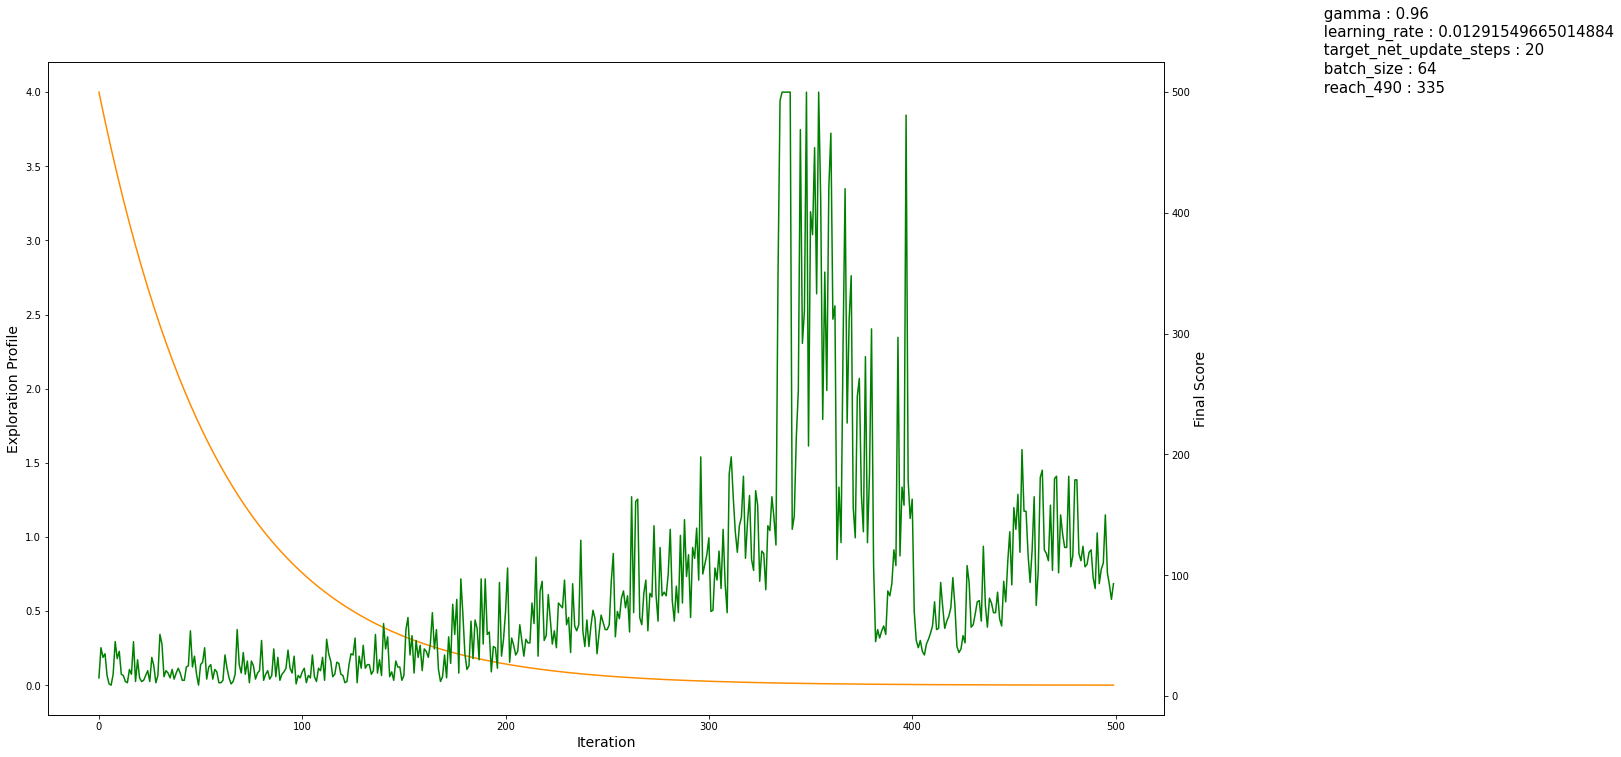

In [21]:
fig, ax = plt.subplots(figsize=(20,12))

ax.plot(exploration_profile,color="darkorange")
ax.set_xlabel('Iteration', fontsize=14)
ax.set_ylabel('Exploration Profile', fontsize=14)
ax.tick_params(axis='y')

ax2 = ax.twinx()
ax2.set_ylabel('Final Score', fontsize=14)
ax2.plot(all_train_scores[np.argmin(reach_490)],color="green")
ax2.tick_params(axis='y')
ax.text(600,4, f" gamma : {best_param['gamma']} \n learning_rate : {best_param['learning_rate'] }\n target_net_update_steps : {best_param['target_net_update_steps'] }\n batch_size : {best_param['batch_size'] }\n reach_490 : {best_param['reach_490'] }", fontsize = 15, )
plt.show()

In [22]:
### Initialization
best_param['min_samples_for_training']=1000
best_param['bad_state_penalty']=0
best_param['replay_memory_capacity']=10000

## PUT OPTIMAL PARAM SET
final_replay_mem, final_policy_net, final_target_net, optimizer, loss_fn = initialize(best_param) 

### Training
## PUT OPTIMAL PARAM SET
final_policy_net, final_training_score = train_loop(final_policy_net, final_target_net, final_replay_mem, 
                                                    exploration_profile, best_param)

torch.save(final_policy_net.state_dict(), 'final_cartpole')


INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 15:21:37,500] Making new env: CartPole-v1
/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


  0%|          | 0/500 [00:00<?, ?it/s]

In [23]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

## LOAD FINAL NETWORK
final_policy_net.load_state_dict(torch.load('final_cartpole'))
final_policy_net.to(device)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(final_policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()


INFO:gym.envs.registration:Making new env: CartPole-v1
[2022-08-30 15:23:33,500] Making new env: CartPole-v1
INFO:gym.wrappers.monitoring:Clearing 22 monitor files from previous run (because force=True was provided)
[2022-08-30 15:23:33,523] Clearing 22 monitor files from previous run (because force=True was provided)
INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.2.2370.video000000.mp4
[2022-08-30 15:23:33,531] Starting new video recorder writing to /content/video/openaigym.video.2.2370.video000000.mp4


EPISODE 1 - FINAL SCORE: 112.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.2.2370.video000001.mp4
[2022-08-30 15:23:35,542] Starting new video recorder writing to /content/video/openaigym.video.2.2370.video000001.mp4


EPISODE 2 - FINAL SCORE: 115.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.2.2370.video000002.mp4
[2022-08-30 15:23:37,262] Starting new video recorder writing to /content/video/openaigym.video.2.2370.video000002.mp4


EPISODE 3 - FINAL SCORE: 142.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.2.2370.video000003.mp4
[2022-08-30 15:23:39,424] Starting new video recorder writing to /content/video/openaigym.video.2.2370.video000003.mp4


EPISODE 4 - FINAL SCORE: 89.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.2.2370.video000004.mp4
[2022-08-30 15:23:40,821] Starting new video recorder writing to /content/video/openaigym.video.2.2370.video000004.mp4


EPISODE 5 - FINAL SCORE: 134.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.2.2370.video000005.mp4
[2022-08-30 15:23:42,783] Starting new video recorder writing to /content/video/openaigym.video.2.2370.video000005.mp4


EPISODE 6 - FINAL SCORE: 104.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.2.2370.video000006.mp4
[2022-08-30 15:23:44,516] Starting new video recorder writing to /content/video/openaigym.video.2.2370.video000006.mp4


EPISODE 7 - FINAL SCORE: 96.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.2.2370.video000007.mp4
[2022-08-30 15:23:46,017] Starting new video recorder writing to /content/video/openaigym.video.2.2370.video000007.mp4


EPISODE 8 - FINAL SCORE: 120.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.2.2370.video000008.mp4
[2022-08-30 15:23:47,751] Starting new video recorder writing to /content/video/openaigym.video.2.2370.video000008.mp4


EPISODE 9 - FINAL SCORE: 107.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.2.2370.video000009.mp4
[2022-08-30 15:23:49,368] Starting new video recorder writing to /content/video/openaigym.video.2.2370.video000009.mp4


EPISODE 10 - FINAL SCORE: 103.0

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/content/video')
[2022-08-30 15:23:51,105] Finished writing results. You can upload them to the scoreboard via gym.upload('/content/video')


In [24]:
### Create environment
env = gym.make('MountainCar-v0') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

INFO:gym.envs.registration:Making new env: MountainCar-v0
[2022-08-30 15:23:54,712] Making new env: MountainCar-v0
/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


STATE SPACE SIZE: 2

ACTION SPACE SIZE: 3

In [25]:
# Define an example network
net = DQN(state_space_dim, action_space_dim)
print(net)

DQN(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

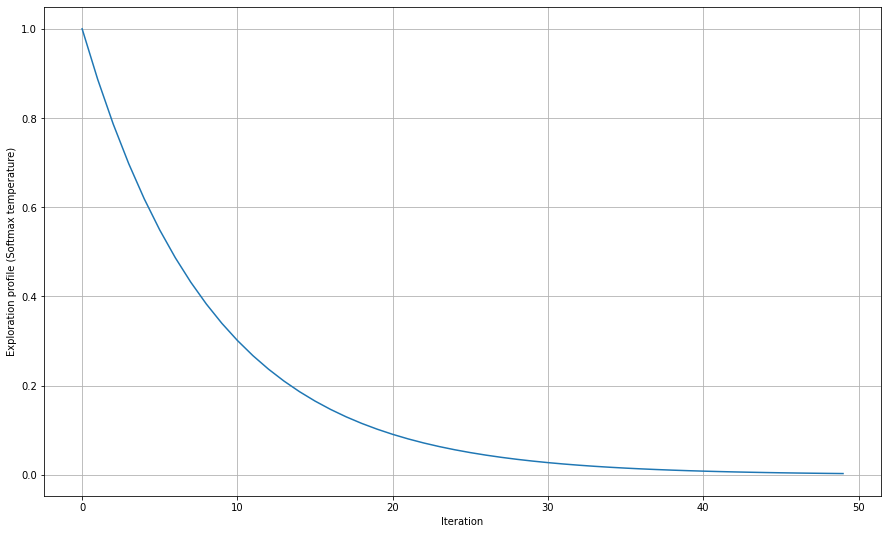

In [26]:
initial_value = 1
num_iterations = 50

exploration_profile = expl_profile_softmax(num_iterations,initial_value)

### Plot exploration profile
plt.figure(figsize=(15,9))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [27]:
state = (0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 0

Q-VALUES: [-0.01601172  0.00891807  0.07674238]

In [28]:
## PARAMETERS

car_params = {'gamma': 0.95,                   # gamma parameter for the long term reward
              'replay_memory_capacity': 10000, # Replay memory capacity
              'learning_rate': 0.1,            # Optimizer learning rate
              'target_net_update_steps': 5,    # Number of episodes to wait before updating the target network
              'batch_size': 32,                # Number of samples to take from the replay memory for each update
              'bad_state_penalty': 0,          # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
              'min_samples_for_training': 1000 # Minimum samples in the replay memory to enable the training
             }

In [32]:
### Initialization
replay_mem, policy_net, target_net, optimizer, loss_fn = initialize(car_params, action_space_dim=action_space_dim, state_space_dim=state_space_dim)

### Training
policy_net, positions, training_score = train_loop_car(policy_net, target_net, replay_mem, exploration_profile, car_params)


INFO:gym.envs.registration:Making new env: MountainCar-v0
[2022-08-30 15:27:38,557] Making new env: MountainCar-v0
/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


  0%|          | 0/50 [00:00<?, ?it/s]

EPISODE: 1 - Max Position: -0.3337656891088244 - Score: -115.0 - Temperature: 1.0

EPISODE: 2 - Max Position: -0.31795428261109104 - Score: -135.0 - Temperature: 0.8869204367171575

EPISODE: 3 - Max Position: -0.3690166281829992 - Score: -123.0 - Temperature: 0.7866278610665535

EPISODE: 4 - Max Position: -0.42783833638554214 - Score: -112.0 - Temperature: 0.697676326071031

EPISODE: 5 - Max Position: -0.3137740922272297 - Score: -120.0 - Temperature: 0.6187833918061408

EPISODE: 6 - Max Position: -0.42597133335238935 - Score: -102.0 - Temperature: 0.5488116360940264

EPISODE: 7 - Max Position: -0.2621801005401561 - Score: -99.0 - Temperature: 0.4867522559599717

EPISODE: 8 - Max Position: -0.2815626836535589 - Score: -84.0 - Temperature: 0.4317105234290797

EPISODE: 9 - Max Position: -0.44030332353903007 - Score: -100.0 - Temperature: 0.38289288597511206

EPISODE: 10 - Max Position: -0.29688502759450963 - Score: -93.0 - Temperature: 0.3395955256449391

EPISODE: 11 - Max Position: -0.32361887545811635 - Score: -87.0 - Temperature: 0.301194211912202

EPISODE: 12 - Max Position: -0.31153264554076354 - Score: -94.0 - Temperature: 0.26713530196585034

EPISODE: 13 - Max Position: -0.24860908085211386 - Score: -87.0 - Temperature: 0.23692775868212176

EPISODE: 14 - Max Position: -0.301366941541003 - Score: -91.0 - Temperature: 0.21013607120076472

EPISODE: 15 - Max Position: -0.4104217340645938 - Score: -93.0 - Temperature: 0.18637397603940994

EPISODE: 16 - Max Position: 0.07243823470666799 - Score: -68.0 - Temperature: 0.16529888822158656

EPISODE: 17 - Max Position: -0.39215800938816536 - Score: -93.0 - Temperature: 0.14660696213035015

EPISODE: 18 - Max Position: 0.3030034688506205 - Score: -67.0 - Temperature: 0.1300287108784259

EPISODE: 19 - Max Position: 0.14830101536765775 - Score: -67.0 - Temperature: 0.11532512103806251

EPISODE: 20 - Max Position: 0.5156016585613692 - Score: -44.0 - Temperature: 0.10228420671553744

EPISODE: 21 - Max Position: 0.09910175944661348 - Score: -56.0 - Temperature: 0.09071795328941247

EPISODE: 22 - Max Position: 0.5326164624500399 - Score: -41.0 - Temperature: 0.08045960674953244

EPISODE: 23 - Max Position: -0.0822542269080331 - Score: -73.0 - Temperature: 0.07136126955638605

EPISODE: 24 - Max Position: 0.5403951701385349 - Score: -30.0 - Temperature: 0.0632917683596407

EPISODE: 25 - Max Position: 0.54311580668423 - Score: -23.0 - Temperature: 0.056134762834133725

EPISODE: 26 - Max Position: 0.5246898919552789 - Score: -30.0 - Temperature: 0.049787068367863944

EPISODE: 27 - Max Position: 0.5020277182141375 - Score: -28.0 - Temperature: 0.04415716841969286

EPISODE: 28 - Max Position: 0.5054406827431933 - Score: -41.0 - Temperature: 0.039163895098987066

EPISODE: 29 - Max Position: -0.2641202263475444 - Score: -68.0 - Temperature: 0.03473525894473855

EPISODE: 30 - Max Position: 0.5221237649250914 - Score: -40.0 - Temperature: 0.03080741103275109

EPISODE: 31 - Max Position: 0.5082147865125685 - Score: -29.0 - Temperature: 0.02732372244729257

EPISODE: 32 - Max Position: 0.5368577983788596 - Score: -26.0 - Temperature: 0.024233967845691123

EPISODE: 33 - Max Position: -0.2080005678145578 - Score: -51.0 - Temperature: 0.021493601345089923

EPISODE: 34 - Max Position: 0.5057381718567397 - Score: -15.0 - Temperature: 0.019063114291611637

EPISODE: 35 - Max Position: 0.001199071115608824 - Score: -41.0 - Temperature: 0.01690746565270528

EPISODE: 36 - Max Position: 0.5129872692682291 - Score: -29.0 - Temperature: 0.014995576820477717

EPISODE: 37 - Max Position: 0.5368577983788596 - Score: -22.0 - Temperature: 0.013299883542443767

EPISODE: 38 - Max Position: 0.5368577983788596 - Score: -20.0 - Temperature: 0.011795938519751572

EPISODE: 39 - Max Position: 0.5368577983788596 - Score: -23.0 - Temperature: 0.010462058943426795

EPISODE: 40 - Max Position: 0.5368577983788596 - Score: -30.0 - Temperature: 0.009279013887064744

EPISODE: 41 - Max Position: 0.515207427528975 - Score: -11.0 - Temperature: 0.008229747049020023

EPISODE: 42 - Max Position: 0.5051626110451518 - Score: -10.0 - Temperature: 0.007299130846788583

EPISODE: 43 - Max Position: 0.5057381718567397 - Score: -8.0 - Temperature: 0.006473748318289405

EPISODE: 44 - Max Position: 0.5223319416505147 - Score: -35.0 - Temperature: 0.005741699685654202

EPISODE: 45 - Max Position: 0.508977815551455 - Score: -3.0 - Temperature: 0.00509243079269919

EPISODE: 46 - Max Position: 0.5054406827431933 - Score: -13.0 - Temperature: 0.004516580942612666

EPISODE: 47 - Max Position: 0.5368577983788596 - Score: -22.0 - Temperature: 0.004005847942090417

EPISODE: 48 - Max Position: 0.5027029638555975 - Score: -4.0 - Temperature: 0.003552868406221362

EPISODE: 49 - Max Position: 0.5368577983788596 - Score: -13.0 - Temperature: 0.0031511115984444414

EPISODE: 50 - Max Position: 0.508436222556465 - Score: -4.0 - Temperature: 0.0027947852750368437

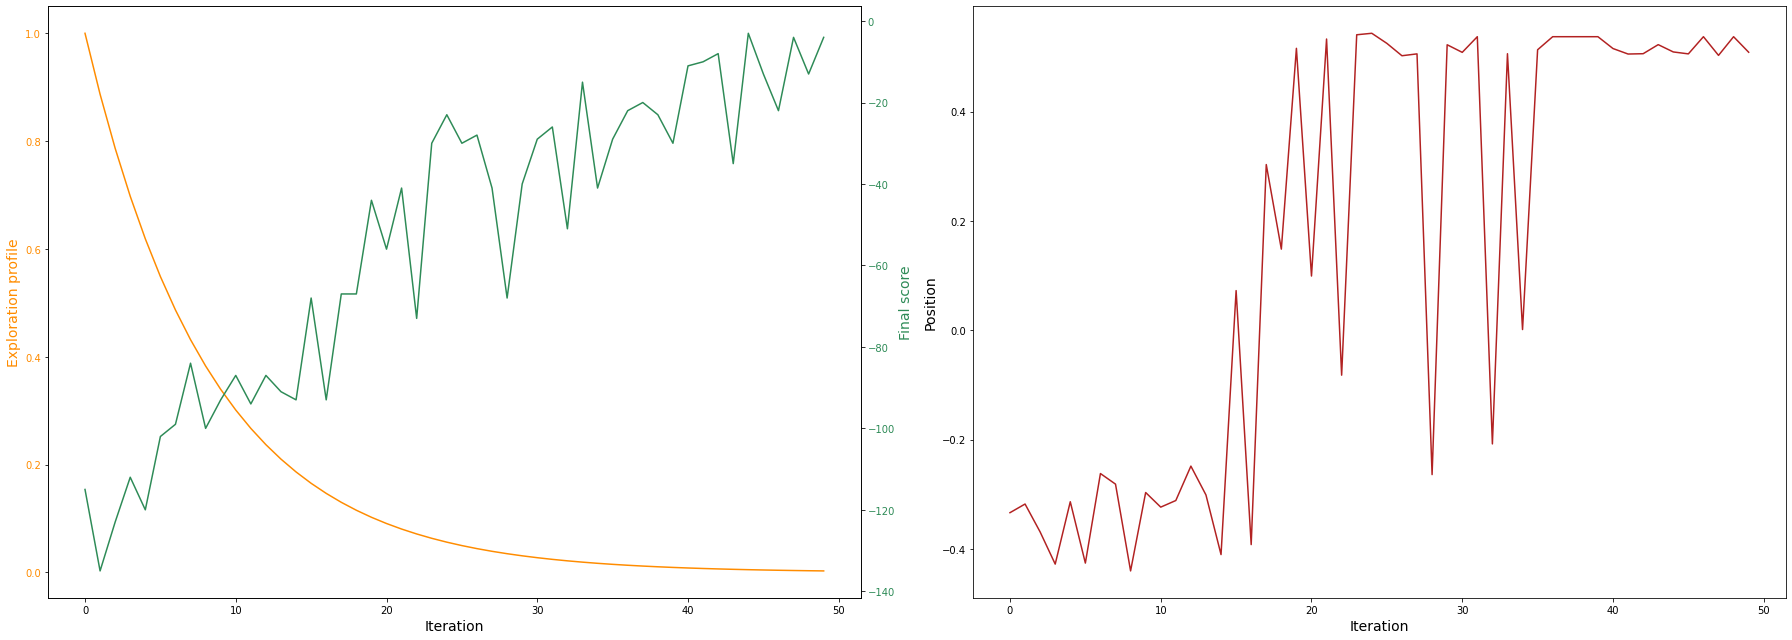

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(25,9))

col = 'darkorange'
ax[0].set_xlabel('Iteration', fontsize=14)
ax[0].set_ylabel('Exploration profile', c=col, fontsize=14)
ax[0].plot(exploration_profile, c=col)
ax[0].tick_params(axis='y', labelcolor=col)

ax2 = ax[0].twinx() 

col = 'seagreen'
ax2.set_ylabel('Final score', c=col, fontsize=14)
ax2.plot(training_score, c=col)
ax2.tick_params(axis='y', labelcolor=col)

ax[1].set_xlabel('Iteration', fontsize=14)
ax[1].set_ylabel('Position', fontsize=14)
ax[1].plot(positions, c='firebrick')

fig.tight_layout()  
plt.show()

In [34]:
torch.save(policy_net.state_dict(), 'mountain_car')

In [35]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(0) # Set a random seed for the environment (reproducible results)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
net = DQN(state_space_dim, action_space_dim)
net.to(device)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    done = False
    max_position = state[0]
    # Go on until the pole falls off or the score reach 490
    while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Visually render the environment
        env.render()
        # Update the final score (+1 for each step)
        # Tracking maximum reached distance
        if next_state[0] > max_position:
            max_position = next_state[0]
            
        # Set the current state for the next iteration
        state = next_state
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - Max Position: {max_position}") 
env.close()

INFO:gym.envs.registration:Making new env: MountainCar-v0
[2022-08-30 15:28:52,027] Making new env: MountainCar-v0
/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2022-08-30 15:28:52,043] Clearing 2 monitor files from previous run (because force=True was provided)
INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.4.2370.video000000.mp4
[2022-08-30 15:28:52,052] Starting new video recorder writing to /content/video/openaigym.video.4.2370.video000000.mp4


EPISODE 1 - Max Position: -0.5890998569071061

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.4.2370.video000001.mp4
[2022-08-30 15:28:55,749] Starting new video recorder writing to /content/video/openaigym.video.4.2370.video000001.mp4


EPISODE 2 - Max Position: 0.517362709859942

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.4.2370.video000002.mp4
[2022-08-30 15:28:57,564] Starting new video recorder writing to /content/video/openaigym.video.4.2370.video000002.mp4


EPISODE 3 - Max Position: 0.5363251097334638

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.4.2370.video000003.mp4
[2022-08-30 15:29:00,462] Starting new video recorder writing to /content/video/openaigym.video.4.2370.video000003.mp4


EPISODE 4 - Max Position: -0.541894486561519

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.4.2370.video000004.mp4
[2022-08-30 15:29:03,891] Starting new video recorder writing to /content/video/openaigym.video.4.2370.video000004.mp4


EPISODE 5 - Max Position: -0.5794415723094362

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.4.2370.video000005.mp4
[2022-08-30 15:29:07,396] Starting new video recorder writing to /content/video/openaigym.video.4.2370.video000005.mp4


EPISODE 6 - Max Position: 0.5363251097334638

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.4.2370.video000006.mp4
[2022-08-30 15:29:10,301] Starting new video recorder writing to /content/video/openaigym.video.4.2370.video000006.mp4


EPISODE 7 - Max Position: -0.5214454780226725

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.4.2370.video000007.mp4
[2022-08-30 15:29:13,743] Starting new video recorder writing to /content/video/openaigym.video.4.2370.video000007.mp4


EPISODE 8 - Max Position: 0.5363251097334638

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.4.2370.video000008.mp4
[2022-08-30 15:29:16,789] Starting new video recorder writing to /content/video/openaigym.video.4.2370.video000008.mp4


EPISODE 9 - Max Position: -0.5880000324392106

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /content/video/openaigym.video.4.2370.video000009.mp4
[2022-08-30 15:29:20,163] Starting new video recorder writing to /content/video/openaigym.video.4.2370.video000009.mp4


EPISODE 10 - Max Position: -0.494450234290343

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/content/video')
[2022-08-30 15:29:23,755] Finished writing results. You can upload them to the scoreboard via gym.upload('/content/video')
